# Importing the libraries

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow import keras

In [2]:
tf.__version__

'2.9.1'

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
from keras.optimizers import SGD
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

### Data Preparation

#### Create the directory structure

In [4]:
# base_directory
base_directory = 'base_directory'
os.mkdir(base_directory)


In [5]:
# train_directory
train_directory = os.path.join(base_directory, 'train_directory')
os.mkdir(train_directory)

In [6]:
# val_directory
validation_directory = os.path.join(base_directory, 'validation_directory')
os.mkdir(validation_directory)

In [ ]:
# create folders inside train_directory

nv = os.path.join(train_directory, 'nv')
os.mkdir(nv)
mel = os.path.join(train_directory, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_directory, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_directory, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_directory, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_directory, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_directory, 'df')
os.mkdir(df)

In [9]:
# create folders inside val_directory
nv = os.path.join(validation_directory, 'nv')
os.mkdir(nv)
mel = os.path.join(validation_directory, 'mel')
os.mkdir(mel)
bkl = os.path.join(validation_directory, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(validation_directory, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(validation_directory, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(validation_directory, 'vasc')
os.mkdir(vasc)
df = os.path.join(validation_directory, 'df')
os.mkdir(df)

In [10]:
df_data = pd.read_csv('C:\\Users\\SUCHAL\\Downloads\\HAM10000_metadata.csv') 
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [11]:
# this will tell me how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now I filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [12]:
# here I identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [13]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [14]:
# filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

## Dataset Splitting into Training and Test sets

In [15]:
# create the validation set 
y = df['dx']

_, df_validation = train_test_split(df, test_size=0.20, random_state=101, stratify=y)

df_validation.shape

(1103, 8)

In [16]:
# Creating training set excluding all images that are in the Validation Set

# This function identifies if an image is part of the train or val set.
def identify_validation_rows(x):
    # create a list of all the lesion_id's in the val set
    validation_list = list(df_validation['image_id'])
    if str(x) in validation_list:
        return 'validation'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_validation'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_validation'] = df_data['train_or_validation'].apply(identify_validation_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_validation'] == 'train']

In [17]:
print("Number of images in the Train Set = ", len(df_train))
df_train['dx'].value_counts()

Number of images in the Train Set =  8912


nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [18]:
print("Number of images in the Validation Set = ", len(df_validation))
df_validation['dx'].value_counts()

Number of images in the Validation Set =  1103


nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

## Sorting images into Training and test directories

In [19]:
# get the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [20]:
# get a list of images in each of the two folders
images_folder_1 = os.listdir('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_1')
images_folder_2 = os.listdir('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_2')

# get a list of Train and Validation images
train_images_list = list(df_train['image_id'])
validation_images_list = list(df_validation['image_id'])


In [21]:
# transfer the Train Set images

for image in train_images_list:
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in images_folder_1:
        # source path to image
        source_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_1', fname)
        # destination path to image
        destination_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\train_directory', label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(source_path, destination_path)

    if fname in images_folder_2:
        # source path to image
        source_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_2', fname)
        # destination path to image
        destination_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\train_directory', label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(source_path, destination_path)


# transfer the Validation Set images

for image in validation_images_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in images_folder_1:
        # source path to image
        source_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_1', fname)
        # destination path to image
        destination_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\validation_directory', label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(source_path, destination_path)

    if fname in images_folder_2:
        # source path to image
        source_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\Dataset\\HAM10000_images_part_2', fname)
        # destination path to image
        destination_path = os.path.join('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\validation_directory', label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(source_path, destination_path)

In [22]:
print("nv    : ", len(os.listdir('base_directory/train_directory/nv')))
print("mel   : ", len(os.listdir('base_directory/train_directory/mel')))
print("bkl   : ", len(os.listdir('base_directory/train_directory/bkl')))
print("bcc   : ", len(os.listdir('base_directory/train_directory/bcc')))
print("akiec : ", len(os.listdir('base_directory/train_directory/akiec')))
print("vasc  : ", len(os.listdir('base_directory/train_directory/vasc')))
print("df    : ", len(os.listdir('base_directory/train_directory/df')))

nv    :  5822
mel   :  1067
bkl   :  1011
bcc   :  479
akiec :  297
vasc  :  129
df    :  107


C:\Users\SUCHAL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NameError: name 'dx' is not defined

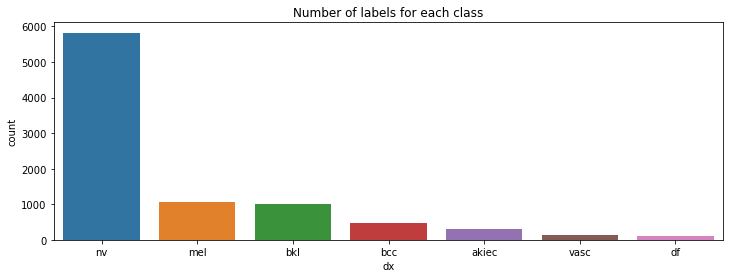

In [23]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.dx, order = data["dx"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["dx"].value_counts().index):
        g.annotate(label[dx], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(df_train)

In [24]:
print("nv    : ", len(os.listdir('base_directory/validation_directory/nv')))
print("mel   : ", len(os.listdir('base_directory/validation_directory/mel')))
print("bkl   : ", len(os.listdir('base_directory/validation_directory/bkl')))
print("bcc   : ", len(os.listdir('base_directory/validation_directory/bcc')))
print("akiec : ", len(os.listdir('base_directory/validation_directory/akiec')))
print("vasc  : ", len(os.listdir('base_directory/validation_directory/vasc')))
print("df    : ", len(os.listdir('base_directory/validation_directory/df')))

nv    :  883
mel   :  46
bkl   :  88
bcc   :  35
akiec :  30
vasc  :  13
df    :  8


C:\Users\SUCHAL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NameError: name 'dx' is not defined

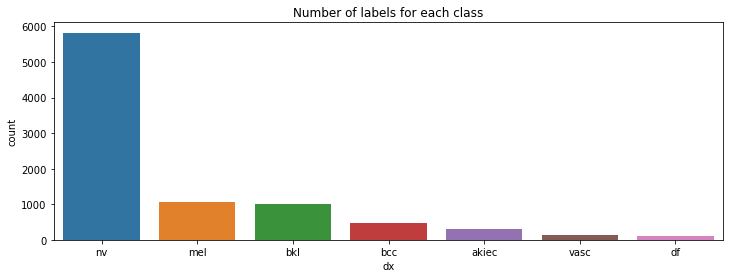

In [25]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.dx, order = data["dx"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["dx"].value_counts().index):
        g.annotate(label[dx], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(df_train)

### Preprocessing the Training set

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\train_directory',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 8912 images belonging to 7 classes.


### Preprocessing the Test set

In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('C:\\Users\\SUCHAL\\Desktop\\Study\\Semester 2\\DMML2\\base_directory\\validation_directory',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1103 images belonging to 7 classes.


## Building the CNN- Part 3

### Initialising the CNN

In [28]:
cnn = tf.keras.models.Sequential()

### Convolution layer

In [29]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

### Pooling

In [30]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [31]:
cnn.add(tf.keras.layers.Dropout(0.25))

### Adding a second convolutional layer

In [32]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Flattening

In [33]:
cnn.add(tf.keras.layers.Flatten())

### Full connection

In [34]:
cnn.add(tf.keras.layers.Dense(units=1024, activation='relu'))

### Output layer

In [35]:
cnn.add(tf.keras.layers.Dense(units=7, activation='softmax'))

## Training the CNN- Part 4

In [36]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
history =cnn.fit(x = training_set, validation_data = test_set, epochs = 100)

Epoch 1/100
279/279 [==============================] - 321s 1s/step - loss: 0.9161 - accuracy: 0.6643 - val_loss: 0.8397 - val_accuracy: 0.8015
Epoch 2/100
279/279 [==============================] - 319s 1s/step - loss: 0.8530 - accuracy: 0.6814 - val_loss: 0.5743 - val_accuracy: 0.8341
Epoch 3/100
279/279 [==============================] - 323s 1s/step - loss: 0.8118 - accuracy: 0.7010 - val_loss: 0.6759 - val_accuracy: 0.8323
Epoch 4/100
279/279 [==============================] - 323s 1s/step - loss: 0.7936 - accuracy: 0.7079 - val_loss: 0.5341 - val_accuracy: 0.8368
Epoch 5/100
279/279 [==============================] - 333s 1s/step - loss: 0.7649 - accuracy: 0.7179 - val_loss: 0.5922 - val_accuracy: 0.8286
Epoch 6/100
279/279 [==============================] - 341s 1s/step - loss: 0.7390 - accuracy: 0.7218 - val_loss: 0.4986 - val_accuracy: 0.8305
Epoch 7/100
279/279 [==============================] - 347s 1s/step - loss: 0.7204 - accuracy: 0.7317 - val_loss: 0.5566 - val_accuracy:

Epoch 57/100
279/279 [==============================] - 187s 670ms/step - loss: 0.1761 - accuracy: 0.9359 - val_loss: 0.6340 - val_accuracy: 0.8450
Epoch 58/100
279/279 [==============================] - 185s 661ms/step - loss: 0.1846 - accuracy: 0.9346 - val_loss: 0.6581 - val_accuracy: 0.8432
Epoch 59/100
279/279 [==============================] - 177s 632ms/step - loss: 0.1717 - accuracy: 0.9391 - val_loss: 0.6591 - val_accuracy: 0.8540
Epoch 60/100
279/279 [==============================] - 176s 630ms/step - loss: 0.1649 - accuracy: 0.9393 - val_loss: 0.6426 - val_accuracy: 0.8477
Epoch 61/100
279/279 [==============================] - 177s 634ms/step - loss: 0.1535 - accuracy: 0.9450 - val_loss: 0.6468 - val_accuracy: 0.8622
Epoch 62/100
279/279 [==============================] - 175s 626ms/step - loss: 0.1547 - accuracy: 0.9436 - val_loss: 0.7188 - val_accuracy: 0.8504
Epoch 63/100
279/279 [==============================] - 175s 626ms/step - loss: 0.1630 - accuracy: 0.9414 - val_

In [62]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

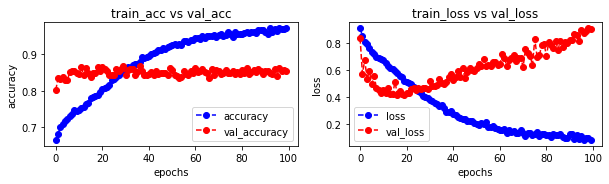

In [63]:
plot_accuracy_loss(history)

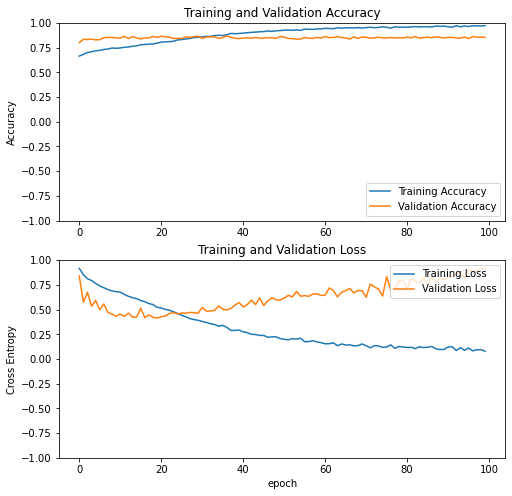

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()